# Information Metrics

Run information theory metrics on time series signals.

In [1]:
from neurodsp.sim import *

import matplotlib.pyplot as plt

import seaborn as sns
sns.set_context('talk')

In [2]:
# Import custom code
import sys; from pathlib import Path
sys.path.append(str(Path('..').resolve()))

from apm.run import run_sims

## Settings

In [6]:
# Simulation settings
n_seconds = 1
fs = 1000

# Set up the simulation parameters
sim_params = {'n_seconds' : n_seconds, 'fs' : fs}

# Set the number of instances to run
n_instances = 50

# Settings for entropy measures
sa_measure_params = {'M' : 5, 'R' : 1}     # Sample Entropy
pe_measure_params = {'n' : 5, 'tau' : 1}   # Permutation Entropy
ap_measure_params = {'M' : 5, 'R' : 1}     # Approximate Entropy

# Set the range of exponents to simulate across
exps = np.arange(-3, 0.25, 0.25)

## Entropy Simulations - Powerlaw

Calculate entropy measures on simulated powerlaw signals.

#### Sample Entropy

In [7]:
# Run a set of simulations, calculating sample entropy across exponents
sa_ents = run_sims(sim_powerlaw, sim_params, samp_entropy, sa_measure_params,
                   update='update_exp', values=exps, n_instances=n_instances)

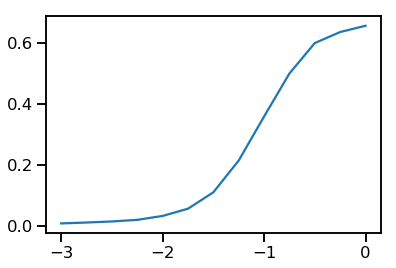

In [8]:
# Plot sample entropy measures across exponent values
plt.plot(exps, sa_ents)

#### Permutation Entropy

In [9]:
# Run a set of simulations, calculating permutation entropy across exponents
pe_ents = run_sims(sim_powerlaw, sim_params, permutation_entropy, pe_measure_params,
                   update='update_exp', values=exps, n_instances=n_instances)

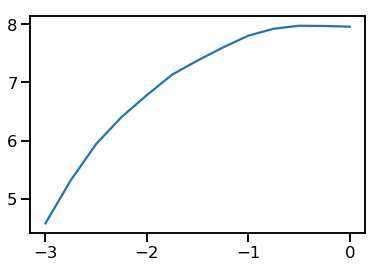

In [10]:
# Plot permutation entropy measures across exponent values
plt.plot(exps, pe_ents)

#### Approximate Entropy

In [11]:
# Run a set of simulations, calculating approximate entropy across exponents
ap_ents = run_sims(sim_powerlaw, sim_params, ap_entropy, ap_measure_params, 
                   update='update_exp', values=exps, n_instances=n_instances)

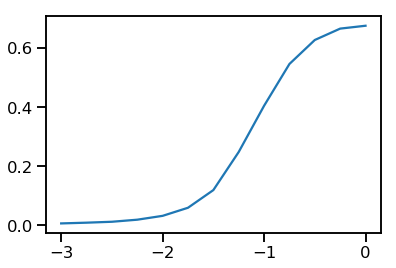

In [12]:
# Plot approximate entropy measures across exponent values
plt.plot(exps, ap_ents)

## Entropy Simulations - Combined Signal with Oscillations

Calculate entropy measures on simulated combined signals, with an oscillation and powerlaw components.

#### Settings

In [13]:
# Reset simulation parameters
sim_params = {'n_seconds' : n_seconds, 'fs' : fs,
              'components' : {'sim_powerlaw' : {'exponent' : -2}, 'sim_oscillation' : {}}}

# Settings for this set of simulations
freqs = np.arange(5, 35, 5)
pows = np.arange(0, 2, 0.1)

#### Sample Entropy

In [14]:
# Run a set of simulations, calculating sample entropy across oscillation frequency
sa_sims_freq = run_sims(sim_combined, sim_params, samp_entropy, sa_measure_params,
                        update='update_freq', values=freqs, n_instances=n_instances)

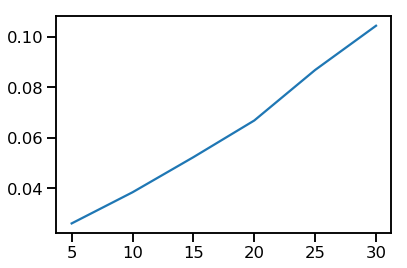

In [15]:
# Plot sample entropy measures across oscillation frequency values
plt.plot(freqs, sa_sims_freq)

In [29]:
# Run a set of simulations, calculating sample entropy across oscillation power
sa_sims_pow = run_sims(sim_combined, sim_params, samp_entropy, sa_measure_params,
                       update='update_pow', values=pows, n_instances=n_instances)

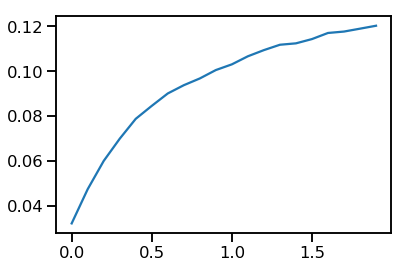

In [30]:
# Plot sample entropy measures across oscillation power values
plt.plot(pows, sa_sims_pow)

#### Permutation Entropy

In [18]:
# Run a set of simulations, calculating permutation entropy across oscillation frequency
pe_sims_freq = run_sims(sim_combined, sim_params, permutation_entropy, pe_measure_params,
                        update='update_freq', values=freqs, n_instances=n_instances)

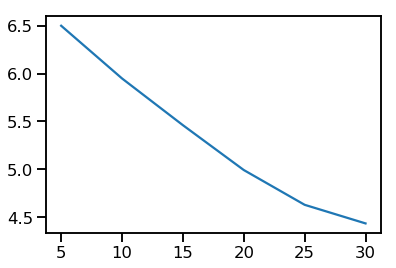

In [19]:
# Plot permutation entropy measures across oscillation frequency values
plt.plot(freqs, pe_sims_freq)

In [20]:
# Run a set of simulations, calculating permutation entropy across oscillation power
pe_sims_pow = run_sims(sim_combined, sim_params, permutation_entropy, pe_measure_params,
                       update='update_pow', values=pows, n_instances=n_instances)

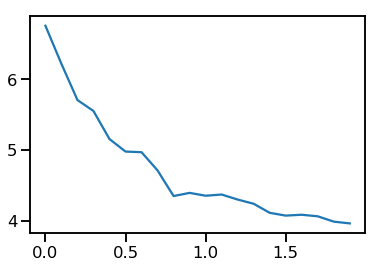

In [21]:
# Plot permutation entropy measures across oscillation power values
plt.plot(pows, pe_sims_pow)

#### Approximate Entropy

In [23]:
# Run a set of simulations, calculating approximate entropy across oscillation frequency
ap_sims_freq = run_sims(sim_combined, sim_params, ap_entropy, ap_measure_params,
                        update='update_freq', values=freqs, n_instances=n_instances)

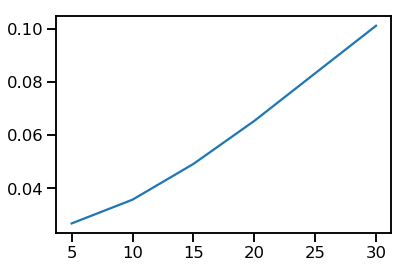

In [24]:
# Plot approximate entropy measures across oscillation frequency values
plt.plot(freqs, ap_sims_freq)

In [27]:
# Run a set of simulations, calculating approximate entropy across oscillation power
ap_sims_pow = run_sims(sim_combined, sim_params, ap_entropy, ap_measure_params,
                       update='update_pow', values=pows, n_instances=n_instances)

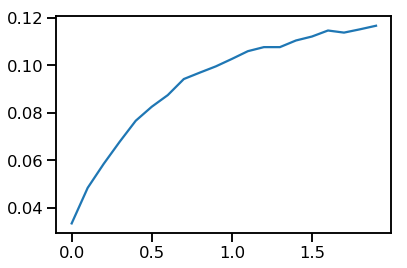

In [28]:
# Plot approximate entropy measures across oscillation power values
plt.plot(pows, ap_sims_pow)

# ENTROPY

In [4]:
# Copied from pyeeg
# https://github.com/forrestbao/pyeeg/blob/master/pyeeg/entropy.py

import numpy

def permutation_entropy(x, n, tau):
    """Compute Permutation Entropy of a given time series x, specified by permutation order n and embedding lag tau.

    Parameters
    ----------
    x : list
        Time series
    n : integer
        Permutation order
    tau : integer
        Embedding lag
        
    Returns
    -------
    PE : float
       Permutation entropy
    
    Notes
    -----
    Suppose the given time series is X =[x(1),x(2),x(3),...,x(N)].
    
    We first build embedding matrix Em, of dimension(n*N-n+1),
    such that the ith row of Em is x(i),x(i+1),..x(i+n-1). Hence
    the embedding lag and the embedding dimension are 1 and n
    respectively. We build this matrix from a given time series,
    X, by calling pyEEg function embed_seq(x,1,n).
    
    We then transform each row of the embedding matrix into
    a new sequence, comprising a set of integers in range of 0,..,n-1.
    
    The order in which the integers are placed within a row is the
    same as those of the original elements:0 is placed where the smallest
    element of the row was and n-1 replaces the largest element of the row.
    
    To calculate the Permutation entropy, we calculate the entropy of PeSeq.
    In doing so, we count the number of occurrences of each permutation
    in PeSeq and write it in a sequence, RankMat. We then use this sequence to
    calculate entropy by using Shannon's entropy formula.
    Permutation entropy is usually calculated with n in range of 3 and 7.
    
    References
    ----------
    Bandt, Christoph, and Bernd Pompe. "Permutation entropy: a natural
    complexity measure for time series." Physical Review Letters 88.17
    (2002): 174102.
    """

    PeSeq = []
    Em = embed_seq(x, tau, n)

    for i in range(len(Em)):
        r, z = [], []

        for j in range(len(Em[i])):
            z.append(Em[i][j])

        for j in range(len(Em[i])):
            
            z.sort()
            r.append(z.index(Em[i][j]))
            z[z.index(Em[i][j])] = -1

        PeSeq.append(r)

    RankMat = []

    while len(PeSeq) > 0:
        RankMat.append(PeSeq.count(PeSeq[0]))
        x = PeSeq[0]
        for j in range(0, PeSeq.count(PeSeq[0])):
            PeSeq.pop(PeSeq.index(x))

    RankMat = numpy.array(RankMat)
    RankMat = numpy.true_divide(RankMat, RankMat.sum())

    EntropyMat = numpy.multiply(numpy.log2(RankMat), RankMat)
    PE = -1 * EntropyMat.sum()

    return PE


def samp_entropy(X, M, R):
    """Computer sample entropy (SampEn) of series X, specified by M and R.
    
    SampEn is very close to ApEn.
    
    Suppose given time series is X = [x(1), x(2), ... , x(N)]. We first build
    embedding matrix Em, of dimension (N-M+1)-by-M, such that the i-th row of
    Em is x(i),x(i+1), ... , x(i+M-1). Hence, the embedding lag and dimension
    are 1 and M-1 respectively. Such a matrix can be built by calling pyeeg
    function as Em = embed_seq(X, 1, M). Then we build matrix Emp, whose only
    difference with Em is that the length of each embedding sequence is M + 1
    
    Denote the i-th and j-th row of Em as Em[i] and Em[j]. Their k-th elements
    are Em[i][k] and Em[j][k] respectively. The distance between Em[i] and
    Em[j] is defined as 1) the maximum difference of their corresponding scalar
    components, thus, max(Em[i]-Em[j]), or 2) Euclidean distance. We say two
    1-D vectors Em[i] and Em[j] *match* in *tolerance* R, if the distance
    between them is no greater than R, thus, max(Em[i]-Em[j]) <= R. Mostly, the
    value of R is defined as 20% - 30% of standard deviation of X.
    
    Pick Em[i] as a template, for all j such that 0 < j < N - M , we can
    check whether Em[j] matches with Em[i]. Denote the number of Em[j],
    which is in the range of Em[i], as k[i], which is the i-th element of the
    vector k.
    
    We repeat the same process on Emp and obtained Cmp[i], 0 < i < N - M.
    The SampEn is defined as log(sum(Cm)/sum(Cmp))
    
    References
    ----------
    Costa M, Goldberger AL, Peng C-K, Multiscale entropy analysis of biological
    signals, Physical Review E, 71:021906, 2005
    
    See also
    --------
    ap_entropy: approximate entropy of a time series
    """

    N = len(X)

    Em = embed_seq(X, 1, M)
    
    A = numpy.tile(Em, (len(Em), 1, 1))
    B = numpy.transpose(A, [1, 0, 2])
    D = numpy.abs(A - B)  # D[i,j,k] = |Em[i][k] - Em[j][k]|
    
    InRange = numpy.max(D, axis=2) <= R
    
    numpy.fill_diagonal(InRange, 0)  # Don't count self-matches

    Cm = InRange.sum(axis=0)  # Probability that random M-sequences are in range
    Dp = numpy.abs(numpy.tile(X[M:], (N - M, 1)) - numpy.tile(X[M:], (N - M, 1)).T)

    Cmp = numpy.logical_and(Dp <= R, InRange[:-1, :-1]).sum(axis=0)

    # Avoid taking log(0)
    Samp_En = numpy.log(numpy.sum(Cm + 1e-100) / numpy.sum(Cmp + 1e-100))

    return Samp_En


def embed_seq(time_series, tau, embedding_dimension):
    """Build a set of embedding sequences from given time series `time_series`
    with lag `tau` and embedding dimension `embedding_dimension`.
    
    Let time_series = [x(1), x(2), ... , x(N)], then for each i such that
    1 < i <  N - (embedding_dimension - 1) * tau,
    we build an embedding sequence,
    Y(i) = [x(i), x(i + tau), ... , x(i + (embedding_dimension - 1) * tau)].
    
    All embedding sequences are placed in a matrix Y.
    
    Parameters
    ----------
    time_series : list or numpy.ndarray
        Time series
    tau : integer
        The lag or delay when building embedding sequence
    embedding_dimension : integer
        The embedding dimension
        
    Returns
    -------
    Y : 2-embedding_dimension list
        Embedding matrix.
    """
    
    if not isinstance(time_series, numpy.ndarray):
        time_series = numpy.asarray(time_series)

    shape = (time_series.size - tau * (embedding_dimension - 1), embedding_dimension)
    strides = (time_series.itemsize, tau * time_series.itemsize)

    return numpy.lib.stride_tricks.as_strided(time_series, shape=shape, strides=strides)

In [5]:
def ap_entropy(X, M, R):
    """Computer approximate entropy (ApEN) of series X, specified by M and R.
    
    Suppose given time series is X = [x(1), x(2), ... , x(N)]. We first build
    embedding matrix Em, of dimension (N-M+1)-by-M, such that the i-th row of
    Em is x(i),x(i+1), ... , x(i+M-1). Hence, the embedding lag and dimension
    are 1 and M-1 respectively. Such a matrix can be built by calling pyeeg
    function as Em = embed_seq(X, 1, M). Then we build matrix Emp, whose only
    difference with Em is that the length of each embedding sequence is M + 1
    Denote the i-th and j-th row of Em as Em[i] and Em[j]. Their k-th elements
    are Em[i][k] and Em[j][k] respectively. The distance between Em[i] and
    Em[j] is defined as 1) the maximum difference of their corresponding scalar
    components, thus, max(Em[i]-Em[j]), or 2) Euclidean distance. We say two
    1-D vectors Em[i] and Em[j] *match* in *tolerance* R, if the distance
    between them is no greater than R, thus, max(Em[i]-Em[j]) <= R. Mostly, the
    value of R is defined as 20% - 30% of standard deviation of X.
    Pick Em[i] as a template, for all j such that 0 < j < N - M + 1, we can
    check whether Em[j] matches with Em[i]. Denote the number of Em[j],
    which is in the range of Em[i], as k[i], which is the i-th element of the
    vector k. The probability that a random row in Em matches Em[i] is
    \simga_1^{N-M+1} k[i] / (N - M + 1), thus sum(k)/ (N - M + 1),
    denoted as Cm[i].
    
    We repeat the same process on Emp and obtained Cmp[i], but here 0<i<N-M
    since the length of each sequence in Emp is M + 1.
    
    The probability that any two embedding sequences in Em match is then
    sum(Cm)/ (N - M +1 ). We define Phi_m = sum(log(Cm)) / (N - M + 1) and
    Phi_mp = sum(log(Cmp)) / (N - M ).
    And the ApEn is defined as Phi_m - Phi_mp.
    
    Notes
    -----
    Please be aware that self-match is also counted in ApEn.
    
    References
    ----------
    Costa M, Goldberger AL, Peng CK, Multiscale entropy analysis of biological
    signals, Physical Review E, 71:021906, 2005
    
    See also
    --------
    samp_entropy: sample entropy of a time series
    """
    
    N = len(X)

    Em = embed_seq(X, 1, M)
    A = numpy.tile(Em, (len(Em), 1, 1))
    B = numpy.transpose(A, [1, 0, 2])
    D = numpy.abs(A - B)  # D[i,j,k] = |Em[i][k] - Em[j][k]|
    InRange = numpy.max(D, axis=2) <= R

    # Probability that random M-sequences are in range
    Cm = InRange.mean(axis=0)

    # M+1-sequences in range if M-sequences are in range & last values are close
    Dp = numpy.abs(
        numpy.tile(X[M:], (N - M, 1)) - numpy.tile(X[M:], (N - M, 1)).T
    )

    Cmp = numpy.logical_and(Dp <= R, InRange[:-1, :-1]).mean(axis=0)

    Phi_m, Phi_mp = numpy.sum(numpy.log(Cm)), numpy.sum(numpy.log(Cmp))

    Ap_En = (Phi_m - Phi_mp) / (N - M)

    return Ap_En


def svd_entropy(X, Tau, DE, W=None):
    """Compute SVD Entropy from either two cases below:
    1. a time series X, with lag tau and embedding dimension dE (default)
    2. a list, W, of normalized singular values of a matrix (if W is provided,
    recommend to speed up.)
    
    If W is None, the function will do as follows to prepare singular spectrum:
        First, computer an embedding matrix from X, Tau and DE using pyeeg
        function embed_seq():
                    M = embed_seq(X, Tau, DE)
        Second, use scipy.linalg function svd to decompose the embedding matrix
        M and obtain a list of singular values:
                    W = svd(M, compute_uv=0)
        At last, normalize W:
                    W /= sum(W)
                    
    Notes
    -----
    To speed up, it is recommended to compute W before calling this function
    because W may also be used by other functions whereas computing it here
    again will slow down.
    """

    if W is None:
        Y = embed_seq(X, Tau, DE)
        W = numpy.linalg.svd(Y, compute_uv=0)
        W /= sum(W)  # normalize singular values

    return -1 * sum(W * numpy.log(W))


def spectral_entropy(X, Band, Fs, Power_Ratio=None):
    """Compute spectral entropy of a time series from either two cases below:
    1. X, the time series (default)
    2. Power_Ratio, a list of normalized signal power in a set of frequency
    bins defined in Band (if Power_Ratio is provided, recommended to speed up)
    In case 1, Power_Ratio is computed by bin_power() function.

    Notes
    -----
    To speed up, it is recommended to compute Power_Ratio before calling this
    function because it may also be used by other functions whereas computing
    it here again will slow down.
    
    Parameters
    ----------
    X : list
        a 1-D real time series.
    Band : list
        boundary frequencies (in Hz) of bins. They can be unequal bins, e.g.
        [0.5,4,7,12,30] which are delta, theta, alpha and beta respectively.
        You can also use range() function of Python to generate equal bins and
        pass the generated list to this function.
        Each element of Band is a physical frequency and shall not exceed the
        Nyquist frequency, i.e., half of sampling frequency.
    Fs : integer
        the sampling rate in physical frequency
    """

    if Power_Ratio is None:
        Power, Power_Ratio = bin_power(X, Band, Fs)

    Spectral_Entropy = 0
    
    for i in range(0, len(Power_Ratio) - 1):
        Spectral_Entropy += Power_Ratio[i] * numpy.log(Power_Ratio[i])
    
    Spectral_Entropy /= numpy.log(len(Power_Ratio))  
    
    # to save time, minus one is omitted
    return -1 * Spectral_Entropy